In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [3]:
# Relationship for "special" FFT
# For both the individual tiles *and* the whole thing, it is true that
# the second half is just the reversed conjugate of the first half.
# In retrospect that shouldn't be a surprise!
a = np.array([1, 0, 0, 0, 3.4, 0, 0, 0, 2.19, 0, 0, 0, 0.765, 0, 0, 0])
print(np.fft.rfft(a))

[ 7.355+0.j    -1.19 -2.635j -0.975-0.j    -1.19 +2.635j  7.355+0.j
 -1.19 -2.635j -0.975+0.j    -1.19 +2.635j  7.355+0.j   ]


In [4]:
# Check that my code works (for a 2d array)
from numpy.fft import fft, fftn, rfft, rfftn, irfftn
Nnum = 4
a = np.random.random((8*Nnum,8*Nnum))
subset = np.zeros(a.shape)
subset[::Nnum, ::Nnum] = a[::Nnum, ::Nnum]
longhandResult = fftn(subset)

reduced = a[::Nnum, ::Nnum]
reducedShape = reduced.shape
fshape = a.shape
reducedF = fftn(reduced, reducedShape)
result = np.tile(reducedF, (1,Nnum))   # edited
#result *= np.exp(-1j * aa * 2*np.pi / fshape[1] * np.arange(result.shape[1]))
result = np.tile(result, (Nnum,1))
#result *= np.exp(-1j * bb * 2*np.pi / fshape[0] * np.arange(result.shape[0]))[:,np.newaxis]

print(np.max(np.abs(result - longhandResult)))

0.0


In [5]:
a = np.pad(np.random.random(16), (0,0), 'constant')
print(a)
print(a[::-1])

[0.30007067 0.27636819 0.67583602 0.92658121 0.78340401 0.72714922
 0.62717675 0.71470031 0.94622124 0.45205058 0.12993665 0.79159769
 0.09187095 0.08947749 0.17376325 0.02510103]
[0.02510103 0.17376325 0.08947749 0.09187095 0.79159769 0.12993665
 0.45205058 0.94622124 0.71470031 0.62717675 0.72714922 0.78340401
 0.92658121 0.67583602 0.27636819 0.30007067]


1.6011864169946884e-15


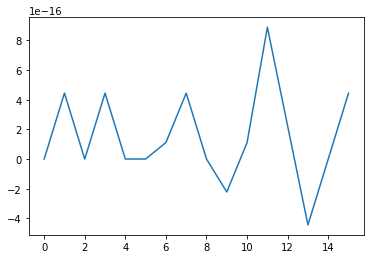

In [6]:
# Relationship between the FT of a and of the reversed version of a
af = np.fft.fft(a)
afm = np.fft.fft(a[::-1])
afm = afm.conj() * np.exp(1j * 2*np.pi / a.shape[0] * np.arange(a.shape[0]))
print(np.max(np.abs(af - afm)))
plt.plot((np.angle(af) - np.angle(afm)))

3.6302085972823607e-14


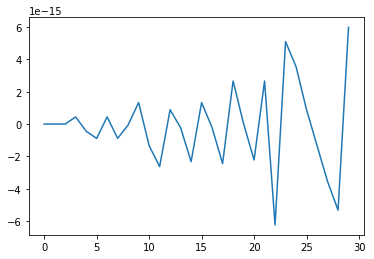

In [7]:
# Relationship between the FT of a and of the reversed version of a when you take into account padding
padLength = 14
af = np.fft.fft(np.pad(a, (0,padLength), 'constant'))
afm = np.fft.fft(np.pad(a[::-1], (0,padLength), 'constant'))
afm = afm.conj() * np.exp(1j * 2*np.pi / af.shape[0] * np.arange(af.shape[0]))
afm *= np.exp(1j * padLength * 2*np.pi / af.shape[0] * np.arange(af.shape[0]))
print(np.max(np.abs(af - afm)))
plt.plot((np.angle(af) - np.angle(afm)))

In [8]:
# Relationship between the FT of a and the transposed version of a when you take into account padding
b = np.random.random((16,16))
bf = np.fft.fft2(np.pad(b, ((0,padLength),(0,padLength)), 'constant'))
bft = np.fft.fft2(np.pad(b.transpose(), ((0,padLength),(0,padLength)), 'constant'))
print(np.max(np.abs(bf - bft.transpose())))

1.4217791915866692e-14


In [11]:
# Work out some code that covers the whole subaperture using mirror/transpose operations
# to minimize the number of times we actually need to compute the FFT of the PSF matrix.

Nnum = 7

covered = np.zeros((Nnum,Nnum))

def process(aa,bb):
    covered[aa,bb] += 1
    
def processFor2(aa,bb,Nnum,mirrorX):
    process(aa,bb)
    if mirrorX:
        process(aa,Nnum-bb-1)

def processFor(aa,bb,Nnum,mirrorX,mirrorY):
    processFor2(aa,bb,Nnum,mirrorX)
    if mirrorY:
        processFor2(Nnum-aa-1,bb,Nnum,mirrorX)
        
    
for aa in range(int((Nnum+1)/2)):
    for bb in range(aa,int((Nnum+1)/2)):
        cent = int(Nnum/2)
        transpose = ((aa != bb) and (aa != (Nnum-bb-1)))
        mirrorX = (bb != cent)
        mirrorY = (aa != cent)
        processFor(aa,bb,Nnum,mirrorX,mirrorY)
        if transpose:
            processFor(bb,aa,Nnum,mirrorY,mirrorX) # Note that mx,my are swapped after transpose

print(covered)

[[1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]]
